In [14]:
from utils import analysis, plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import importlib
importlib.reload(analysis)

burn_in = 0.2

In [15]:
data_name = "G13_COAD_12"

samples = np.load("../results/mcmc/G13_LUAD_12_sym-l2_MALA_0_0015625.npy" if data_name == "G13_LUAD_12"
                  else "../results/mcmc/G13_COAD_12_symsparse_MALA_0_001.npy")[:, ::10]
samples = samples[int(len(samples)*burn_in):]
samples = samples.reshape((-1, samples.shape[-1]))

data = pd.read_csv(f"../data/{data_name}.csv", index_col=0)

In [16]:
n_bins = 100
positions = analysis.event_positions(log_thetas=samples, n_bins=n_bins)

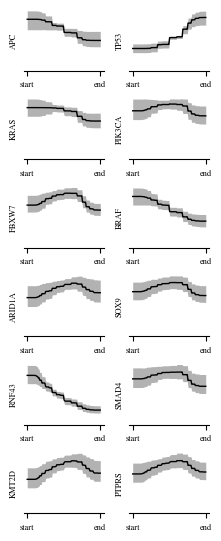

In [18]:
if data_name == "G13_LUAD_12":
    main_events =  np.arange(12)
elif data_name == "G13_COAD_12":
    main_events =  np.arange(12)

n_events = data.shape[1]
event_names = data.columns.tolist()
                            
n_cols = 2
n_rows = (len(main_events) - 1) // n_cols + 1

fig, ax = plt.subplots(
    n_rows, n_cols,
    figsize=(2.2, 0.9 *
            n_rows),
            )

for i, i_event in enumerate(main_events):

    q_5, q_50, q_95 = np.percentile(
        positions[:, i_event, :], [5, 50, 95], axis=0)
    ax[i // n_cols, i % n_cols].plot(
        q_50, lw=1, color="black")
    ax[i // n_cols, i % n_cols].fill_between(
        np.arange(n_bins), q_5, q_95, alpha=0.3, color="black", lw=0
    )
    ax[i // n_cols, i % n_cols].set_ylabel(f"{event_names[i_event]}")
    for spine in ["top", "right", "left"]:
        ax[i // n_cols, i % n_cols].spines[spine].set_visible(False)
    _ = ax[i // n_cols, i % n_cols].set_yticks([])
    _ = ax[i // n_cols, i % n_cols].set_xticks([0, n_bins-1])
    _ = ax[i // n_cols, i % n_cols].set_xticklabels(["start", "end"])
    ax[i // n_cols, i % n_cols].set_ylim(0, None, auto=True)

if len(main_events) % n_cols != 0:
    for i in range(n_cols - (len(main_events) % n_cols)):
        ax[-1, -1 - i].set_visible(False)

fig.tight_layout()
fig.savefig(
    f"../results/figs/{data_name}_symsp_positions.pdf", dpi=600)

## Event Poisitions Predicted by the Different Modes of the L1 Posteriors

In [19]:
import umap
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA

2026-02-02 08:29:47.802692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-02 08:29:47.954872: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-02 08:29:47.959015: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-02-02 08:29:47.959033: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [ ]:
data_name = "G13_LUAD_12"

samples = np.load("../results/mcmc/G13_LUAD_12_l1_MALA_0_001.npy" if data_name == "G13_LUAD_12"
                  else "../results/mcmc/G13_COAD_12_l1_MALA_0_001421875.npy")[:, ::10]
samples = samples[int(len(samples)*burn_in):]
samples = samples.reshape((-1, samples.shape[-1]))

data = pd.read_csv(f"../data/{data_name}.csv", index_col=0)

In [21]:
n_components = 3
clusterable_embedding = umap.UMAP(
    n_components=n_components).fit_transform(samples)
labels = HDBSCAN(
    min_samples=10,
    min_cluster_size=100,
).fit_predict(clusterable_embedding)
standard_embedding = PCA(n_components=n_components).fit_transform(samples)
clustered = (labels >= 0)

In [22]:
unique_labels = np.unique(labels)
unique_labels = unique_labels[unique_labels != -1]

In [ ]:
positions = {
    label: analysis.event_positions(
        log_thetas=samples[labels == label], n_bins=n_bins) \
            for label in np.unique(labels) if label != -1
}

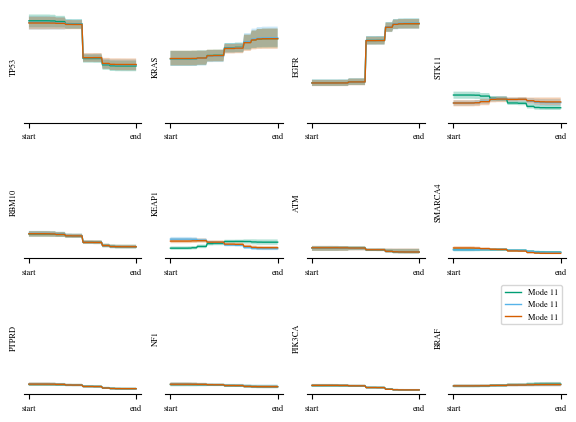

In [41]:
n_cols = 4
n_rows = 3

fig, ax = plt.subplots(n_rows, n_cols, figsize=(7, 5), sharey=True)

for i, i_event in enumerate(main_events):

    for label in unique_labels:

        q_5, q_50, q_95 = np.percentile(
            positions[label][:, i_event, :], [5, 50, 95], axis=0)
        ax[i // n_cols, i % n_cols].plot(
            q_50, lw=1, label=f"Mode {i}")
        ax[i // n_cols, i % n_cols].fill_between(
            np.arange(n_bins), q_5, q_95, alpha=0.3, lw=0
        )
    ax[i // n_cols, i % n_cols].set_ylabel(f"{data.columns[i_event]}")
    for spine in ["top", "right", "left"]:
        ax[i // n_cols, i % n_cols].spines[spine].set_visible(False)
    _ = ax[i // n_cols, i % n_cols].set_yticks([])
    _ = ax[i // n_cols, i % n_cols].set_xticks([0, n_bins-1])
    _ = ax[i // n_cols, i % n_cols].set_xticklabels(["start", "end"])
    ax[i // n_cols, i % n_cols].set_ylim(0, None, auto=True)

ax[-1, -1].legend()


if len(main_events) % n_cols != 0:
    for i in range(n_cols - (len(main_events) % n_cols)):
        ax[-1, -1 - i].set_visible(False)